<a href="https://colab.research.google.com/github/dviva1972/denvlaiva/blob/master/CV_nn_intro_tf_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Реализация логистической регрессии в TensorFlow

In [233]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [234]:
%matplotlib inline
from matplotlib import pyplot as plt

Генерируем данные для задачи регрессии

In [235]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

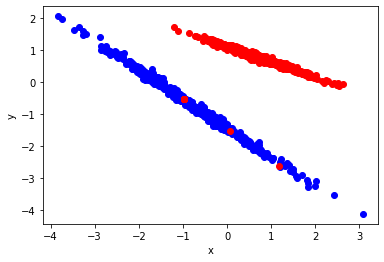

In [236]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 467) 

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

Вспомогательные функции

In [237]:
import random
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    
    name_prefix = ''.join([random.choice(string.ascii_letters) for _ in range(10)])
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

Реализация линейных операций

In [238]:
def linear_op_forward(X, W):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T)  # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads),
                       axis = 0,
                       keep_dims = True)
    return dX, dW

def sigmoid_op_forward(X):
    return (1 / (1 + np.exp(-X))).astype(np.float32)

def sigmoid_op_backward(op, grads):
    X = op.inputs[0]
    name=None
    with tf.name_scope(name, "sigmoid", [X]) as name:
        y = tf.py_func(sigmoid_op_forward, [X], [tf.float32], name=name, stateful=False) 
    out = y[0]
    out = out * (1 - out) 
    return tf.multiply(grads, out)

Создание графа вычислений и обучение модели

In [239]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 54321))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W],            # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бмнарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.9).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов

    # выполняем итерации по эпохам
    for epoch in range(20):
        
        # вначале каждой эпохи перемешиваем индексы
        np.random.shuffle(indices)
        
        # внутри каждой эпохи данные разбиваются на батчи
        for batch in range(len(X) // BATCH_SIZE):
            
            # выбираем индексы очередного батча
            batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

            # выполняем шаг обучения: вычисляем ошибку и обновляем веса
            loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                            plh_labels: y[batch_indices]})
        
            # сохраняем занчения ошибки для построения кривой обучения
            learning_curve.append(loss)
            
            # выводим текущее значение ошибки для каждого 10го шага
            steps = len(learning_curve) - 1
            if steps % 10 == 0:
                print('[%03d] loss=%.3f weights=%s' % (steps, loss, var_W.eval()))
    
    # сохраняем обученные веса
    weights = var_W.eval()

[000] loss=0.799 weights=[[0.33080792 0.18391998]]
[010] loss=0.622 weights=[[-0.45265344 -0.6034656 ]]
[020] loss=0.550 weights=[[-0.97596467 -1.126193  ]]
[030] loss=0.564 weights=[[-1.276966  -1.4866291]]
[040] loss=0.506 weights=[[-1.4928414 -1.7348402]]
[050] loss=0.530 weights=[[-1.6545618 -1.9331002]]
[060] loss=0.505 weights=[[-1.7786477 -2.0962539]]
[070] loss=0.540 weights=[[-1.8830914 -2.2362084]]
[080] loss=0.525 weights=[[-1.9744242 -2.3502352]]
[090] loss=0.526 weights=[[-2.0521812 -2.453996 ]]
[100] loss=0.524 weights=[[-2.12369   -2.5455103]]
[110] loss=0.551 weights=[[-2.1842852 -2.6317518]]
[120] loss=0.549 weights=[[-2.2426007 -2.7052333]]
[130] loss=0.525 weights=[[-2.293524  -2.7745423]]
[140] loss=0.520 weights=[[-2.3415961 -2.8382933]]
[150] loss=0.504 weights=[[-2.3867667 -2.8967943]]
[160] loss=0.500 weights=[[-2.428312  -2.9525714]]
[170] loss=0.495 weights=[[-2.4677405 -3.003804 ]]
[180] loss=0.518 weights=[[-2.5032468 -3.0544672]]
[190] loss=0.483 weights=[[

Визуализируем кривую обучения

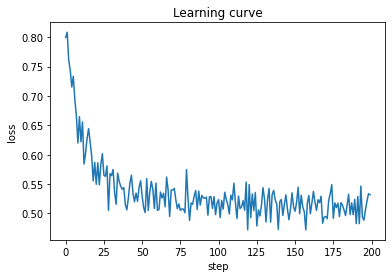

In [240]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);


Визуализируем разделяющую гиперплоскость

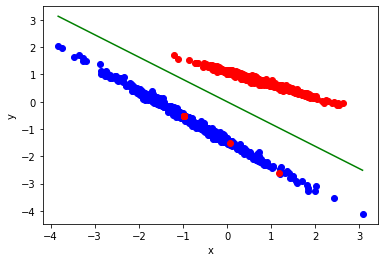

In [241]:
y_pred = - X[:, 0] * weights[0, 0] / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');